In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from torch.utils.data import DataLoader
import os
import matplotlib.pyplot as plt
import sys
sys.path.append('..')
from dataset.sentinel import *
from models.lstm_ae import *
import torch
import random
from config import *
from utils import *

import numpy as np

architecture='lstm_ae'

In [2]:
folders = exp_name_folders(architecture)
exp_dict = {}
for i, exp_name in enumerate(folders):
    
    print(i, exp_name)
    exp_dict[exp_name]=i

KeyError: '13k'

In [ ]:
select_exp = 

In [8]:
added_path = folders[3]
model_list = os.listdir(model_results + '{}/{}'.format(architecture, added_path))
print(added_path)
print(model_list)

6k
['model_1.pt', 'model_2.pt', 'model_3.pt']


In [22]:
model_num = 0

print(model_list[model_num])
model_name = model_list[model_num].split('.')[0]

model_1.pt


In [23]:
model_results+ 'lstm_ae/{}'.format(added_path) + '/' + model_list[model_num]

'/home/robertomorelli/time_series_anomaly_detection/model_results/lstm_ae/pr_1/model_1.pt'

In [41]:
checkpoint  = torch.load(model_results+ 'lstm_ae/{}'.format(added_path) + '/' + model_list[model_num])
params_conf = checkpoint['param_conf']
cfg = checkpoint['cfg']

In [64]:
cols = checkpoint['cfg'].dataset.columns
sequence_length = params_conf['sequence_length']
batch_size = params_conf['batch_size']
predict = params_conf['predict']
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
out_window = params_conf['out_window']

n_features = params_conf['n_features']
scaled = params_conf['scaled']
sampling_rate = params_conf['sampling_rate']
shuffle = False
columns_subset = cfg['dataset']['columns_subset']
dataset_subset = cfg['dataset']['dataset_subset']
dataset_subset = cfg['dataset']['dataset_subset']
train_val_split = cfg.dataset.train_val_split
target = cfg.dataset.target

In [54]:
latent_dim = params_conf['latent_dim']
par_nums = checkpoint['parameters_number']
seq_len = params_conf['sequence_length']

In [55]:
xdf = pd.read_pickle(os.path.join(data_path.strip('..'), "all_2016-2018_clean_std_4s.pkl"))

if columns_subset:
    cols = cols[columns_subset:columns_subset*2]
dataRaw = xdf[cols].dropna()

if dataset_subset:
    dataRaw = dataRaw.iloc[:dataset_subset, :]

In [56]:
df = dataRaw.copy()
x = df.values

if scaled:
    scaler = StandardScaler()
    x_scaled = scaler.fit_transform(x)
    dfNorm = pd.DataFrame(x_scaled, columns=df.columns)
else:
    dfNorm = pd.DataFrame(x, columns=df.columns)

X_train, X_test, y_train, y_test = train_test_split(dfNorm, dfNorm, \
                                                    train_size=train_val_split\
                                                    , shuffle=False)
df_train = pd.DataFrame(X_train, columns=dfNorm.columns)
df_test = pd.DataFrame(X_test, columns=dfNorm.columns)

In [71]:
transform = None

In [73]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

train_dataset = Dataset_seq(df_train, target = target, sequence_length = sequence_length,
                            out_window = out_window, prediction=predict,\
                            transform=transform)
train_iter = DataLoader(dataset=train_dataset,\
                        batch_size=batch_size, shuffle=True)

test_dataset = Dataset_seq(df_test, target = target, \
                           sequence_length = sequence_length,
                            out_window = out_window, prediction=predict,\
                           transform=transform)
test_iter = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

In [74]:
num_batch = 35
shift = np.random.randint(len(test_iter.dataset.df_data)-1000)
#shift = 35592
print(shift)
sigma=5
feats=[0]
batch=[10]
x = np.zeros((num_batch, sequence_length, len(cols)))
for i in range(num_batch):

    x[i,:,:] = test_iter.dataset.df_data.iloc[shift + i*sequence_length:shift + (i+1)*sequence_length,:]\
    .values

    x[i,:,:] = test_iter.dataset.df_data.iloc[shift + i*sequence_length:shift + (i+1)*sequence_length,:]\
    .values
    
xa = x.copy()
for i in feats:
    for j in batch:
        xa[j,:,i] = xa[j,:,i] + sigma*np.std(xa[:,:,i])
     
x = torch.from_numpy(x).float()
xa = torch.from_numpy(xa).float()
x = torch.unsqueeze(x, 1)
xa = torch.unsqueeze(xa, 1)

30361


In [88]:
device = 'cpu'

In [89]:
model = LSTM_AE(seq_in=params_conf['sequence_length'],seq_out=params_conf['out_window'],
        n_features=params_conf['n_features'], output_size=params_conf['output_size'],
        embedding_dim=params_conf['embedding_dim'], latent_dim=params_conf['latent_dim'],
                n_layers_1=params_conf['n_layers'], n_layers_2=params_conf['n_layers'])
model.load_state_dict(checkpoint['model_state_dict'])
model.to(device).eval()

LSTM_AE(
  (encoder): Encoder(
    (LSTMenc): LSTM(16, 32, num_layers=3, batch_first=True)
    (LSTM1): LSTM(32, 16, num_layers=3, batch_first=True)
    (enc): Linear(in_features=16, out_features=10, bias=True)
  )
  (decoder): Decoder(
    (LSTMdec): LSTM(10, 16, num_layers=3, batch_first=True)
    (LSTM1): LSTM(16, 32, num_layers=3, batch_first=True)
    (fc): Linear(in_features=32, out_features=16, bias=True)
  )
)

model = LSTM_AE(seq_in=16,seq_out=16,
        n_features=16, output_size=16,
        embedding_dim=16, latent_dim=40,
                n_layers=1)

In [90]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [91]:
count_parameters(model)

60986

In [92]:
num_batch = 60
shift = np.random.randint(len(test_iter.dataset.df_data)-1000)
#shift = 35592
print(shift)
sigma=5
feats=[0]
batch=[3]
x = np.zeros((num_batch, sequence_length, len(cols)))
for i in range(num_batch):

    x[i,:,:] = test_iter.dataset.df_data.iloc[shift + i*sequence_length:shift + (i+1)*sequence_length,:]\
    .values

    x[i,:,:] = test_iter.dataset.df_data.iloc[shift + i*sequence_length:shift + (i+1)*sequence_length,:]\
    .values
    
xa = x.copy()
for i in feats:
    for j in batch:
        xa[j,:,i] = xa[j,:,i] + sigma*np.std(xa[:,:,i])
     
x = torch.from_numpy(x).float()
xa = torch.from_numpy(xa).float()

196576


In [94]:
#x, y, idx = next(iter(test_iter))
x, enc, yo = model(x.to(device))
xa, enc, ya = model(xa.to(device))

In [95]:
path = './figure_results/lstm_ae/evaluation/{}/{}/feats_{}/shift_{}/'.format(added_path, model_name, feats[0], shift)
print(path)
save = False

./figure_results/lstm_ae/evaluation/pr_1/model_1/feats_0/shift_196576/


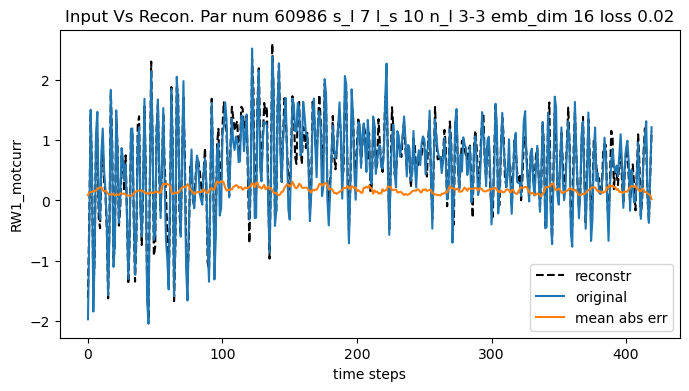

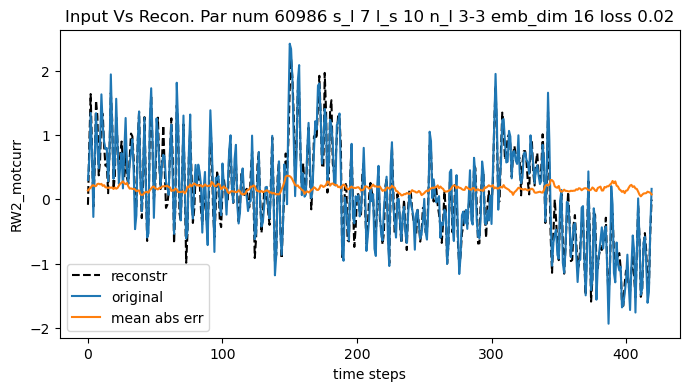

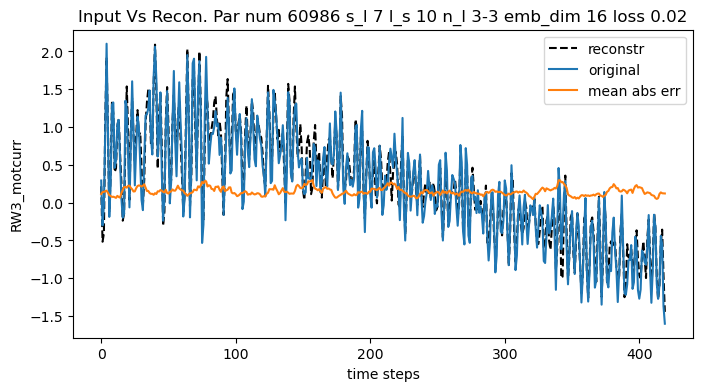

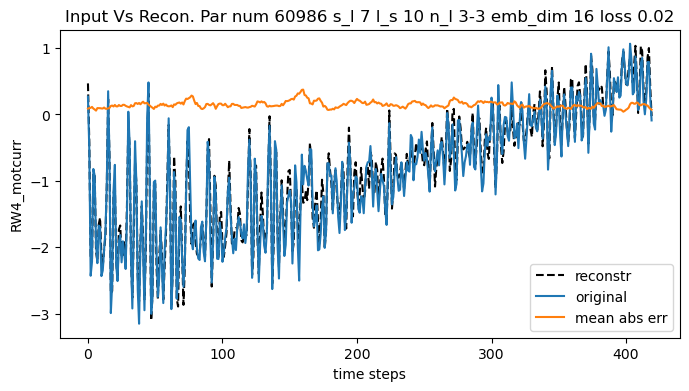

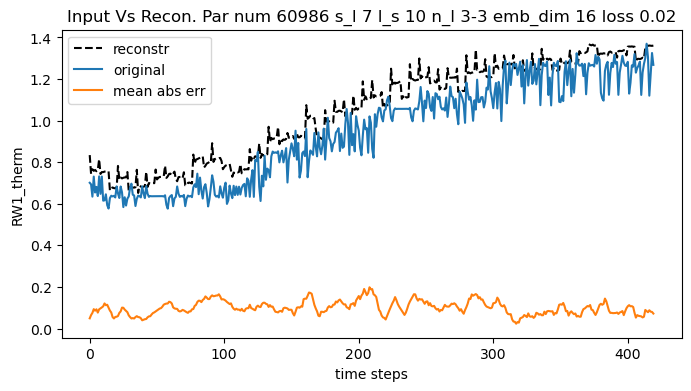

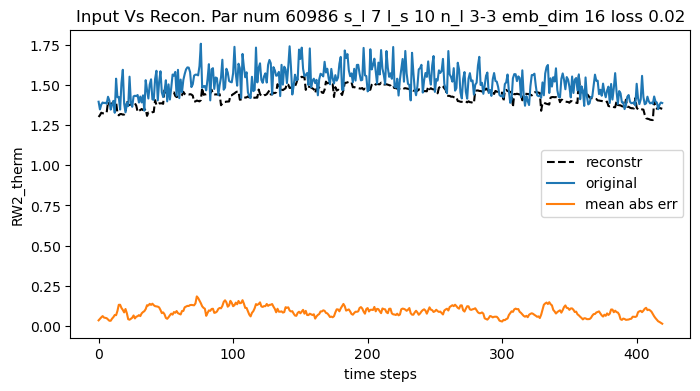

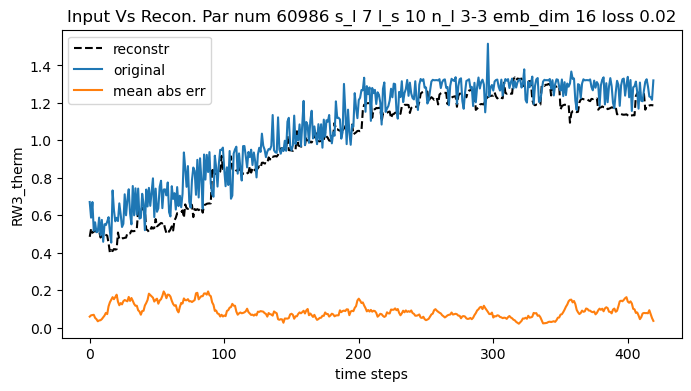

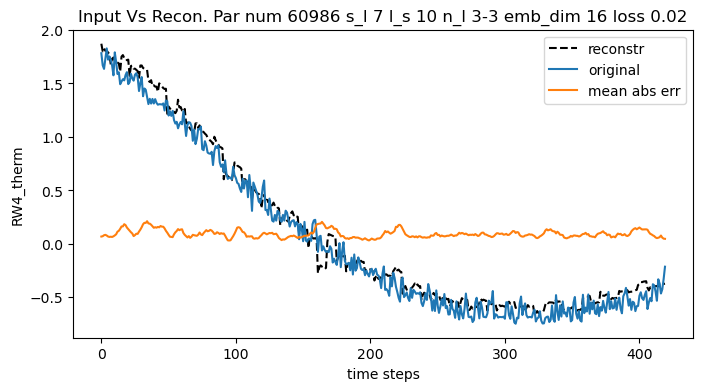

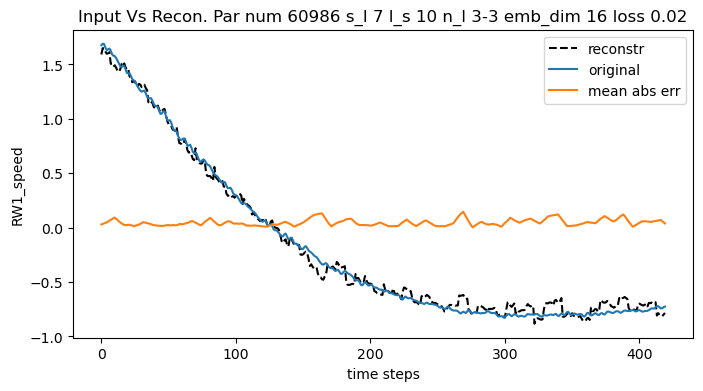

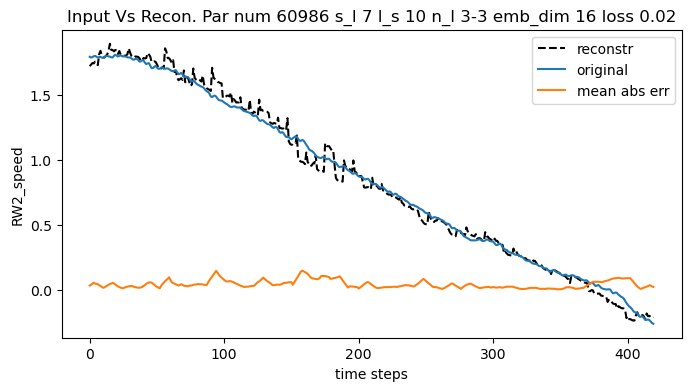

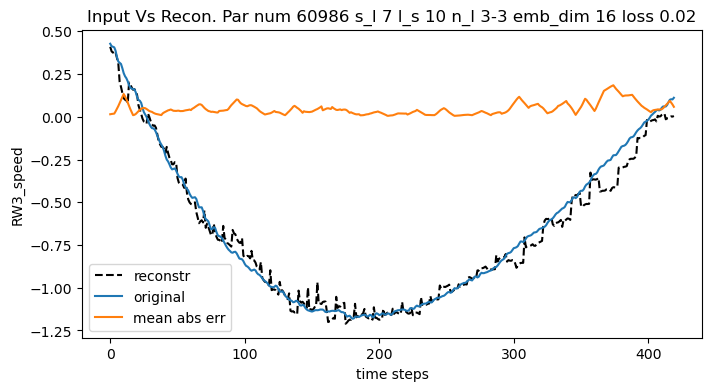

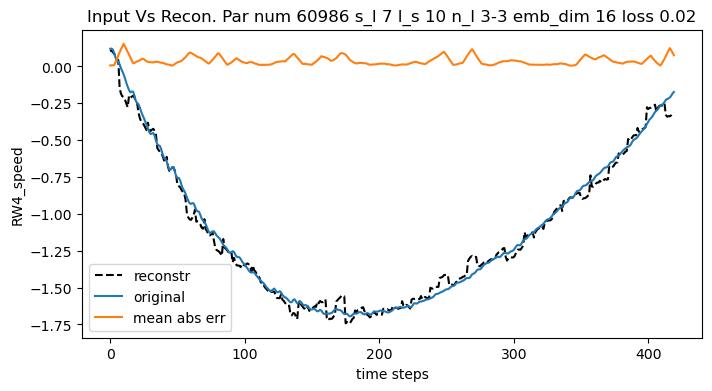

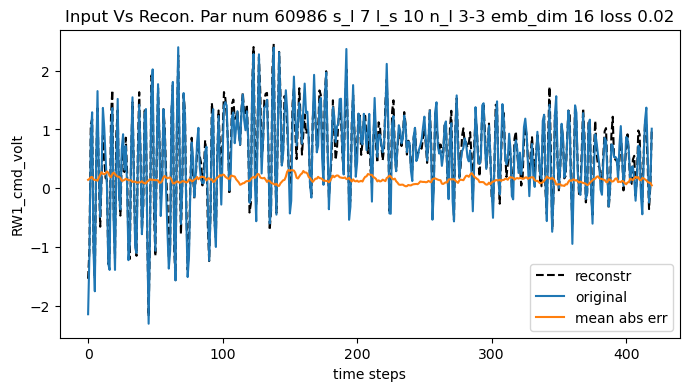

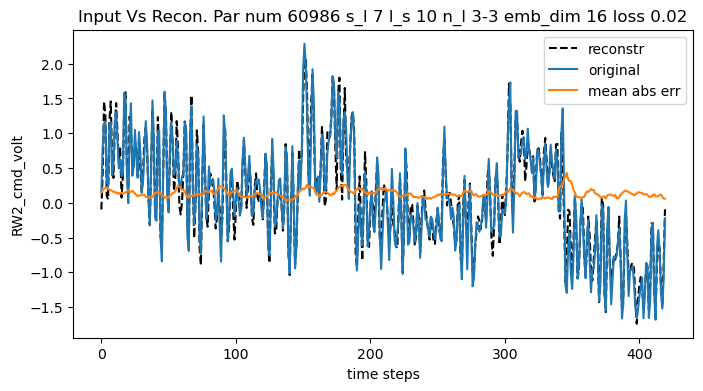

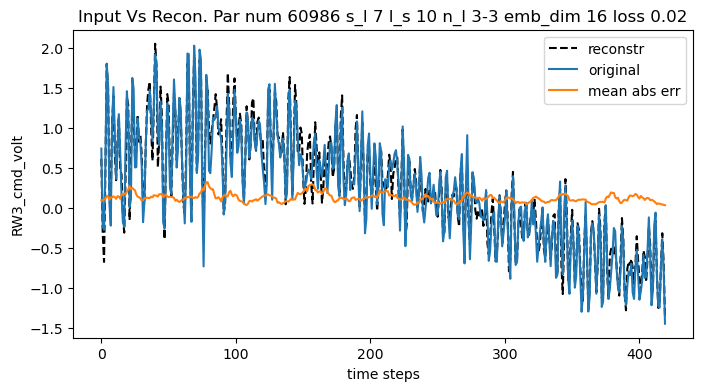

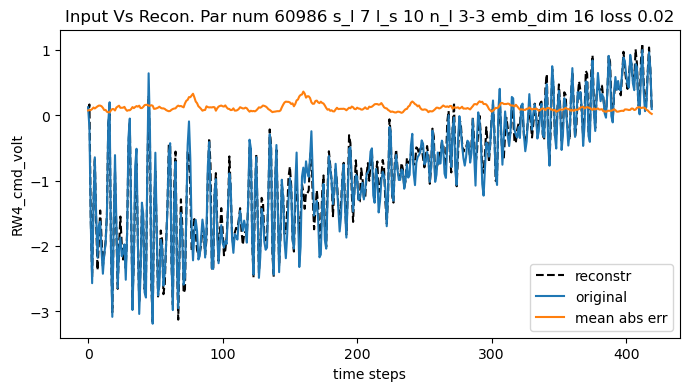

In [103]:
for i in range(x.shape[2]):
    fig, ax = plt.subplots(1,1, figsize=(8,4))

    ax.plot(yo.flatten(0,1)[:,i].to("cpu").detach().numpy(), 
               linestyle='--', label='reconstr', color='black')
    ax.plot(x.flatten(0,1)[:,i].to("cpu").detach().numpy(), label ='original')
    x_i = x.flatten(0,1)[:,i]
    y_o = yo.flatten(0,1)[:,i]

    loss_u = torch.nn.L1Loss(reduction='none')(y_o, x_i)
    loss_u = moving_average(loss_u.to("cpu").detach().numpy(), seq_len)

    ax.plot(loss_u, label ='mean abs err')
    ax.set_xlabel('time steps')
    ax.set_ylabel('{}'.format(cols[i]))
    ax.set_title('Input Vs Recon. Par num {} s_l {} l_s {} n_l {}-{} emb_dim {} loss {}'\
                    .format(par_nums, seq_len, 
                            latent_dim, params_conf['n_layers'],params_conf['n_layers'],
                            params_conf['embedding_dim'],
                            np.round(checkpoint['loss'],2)))    
    ax.legend()
    if save:
        os.makedirs(path, exist_ok=True)
        plt.savefig(path + '{}_shift_{}_{}_sigma_{}_batch_{}.png'.format(cols[i],shift,sigma,i, num_batch))

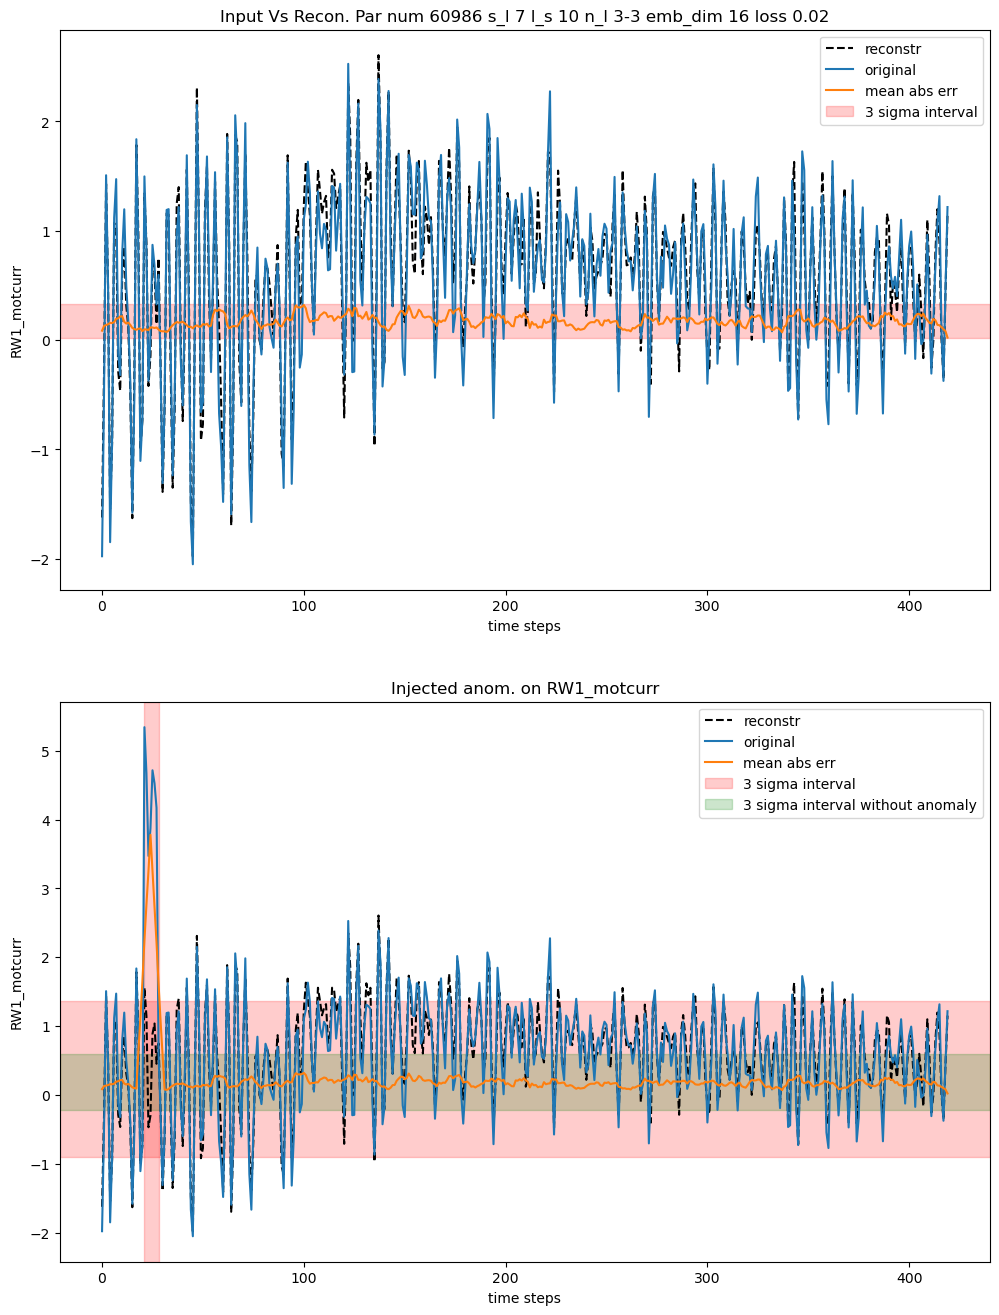

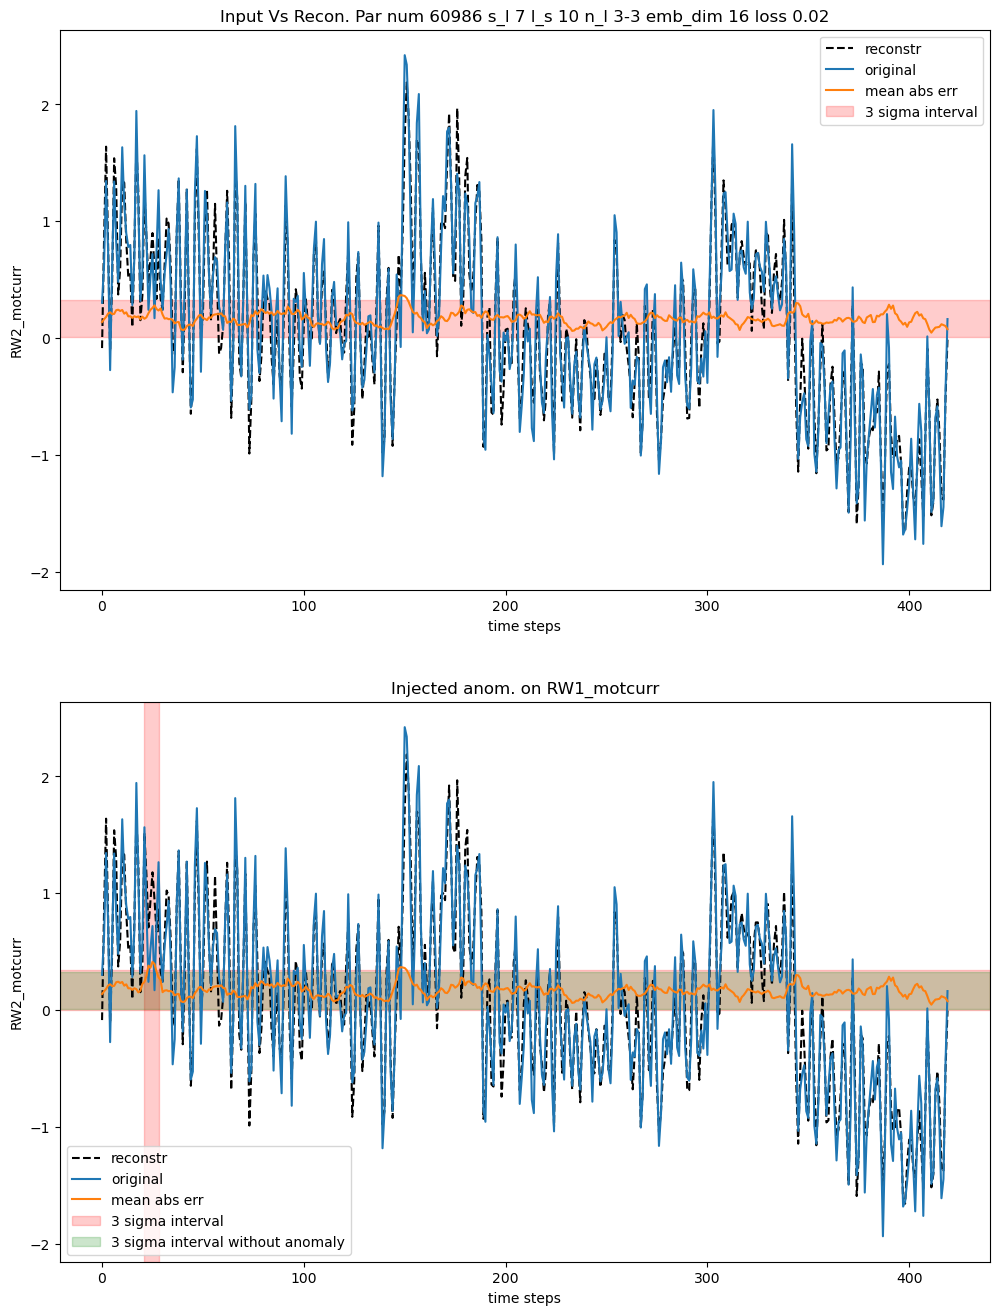

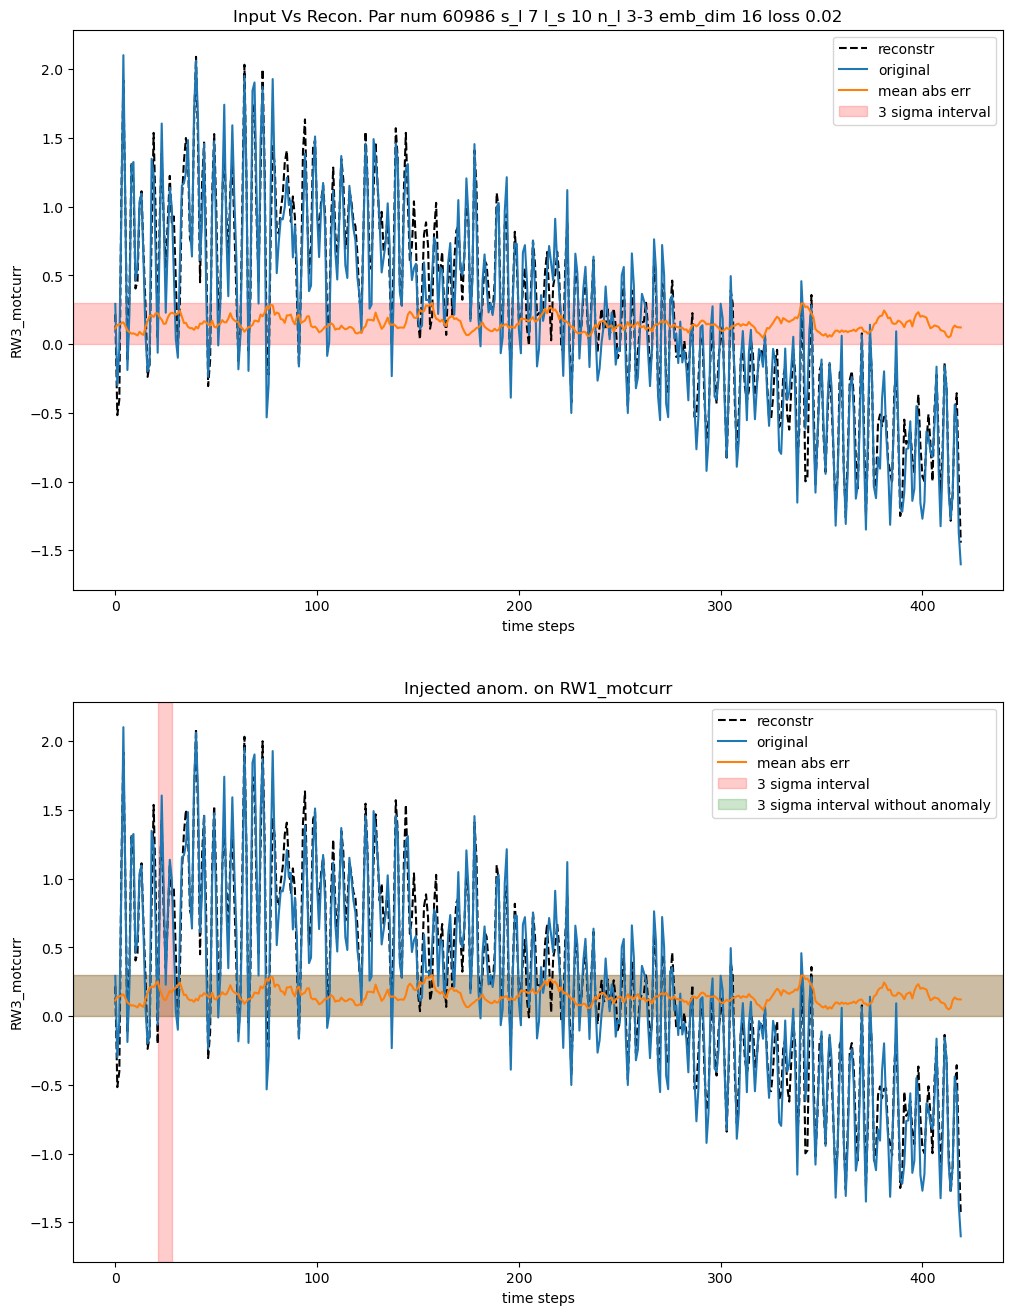

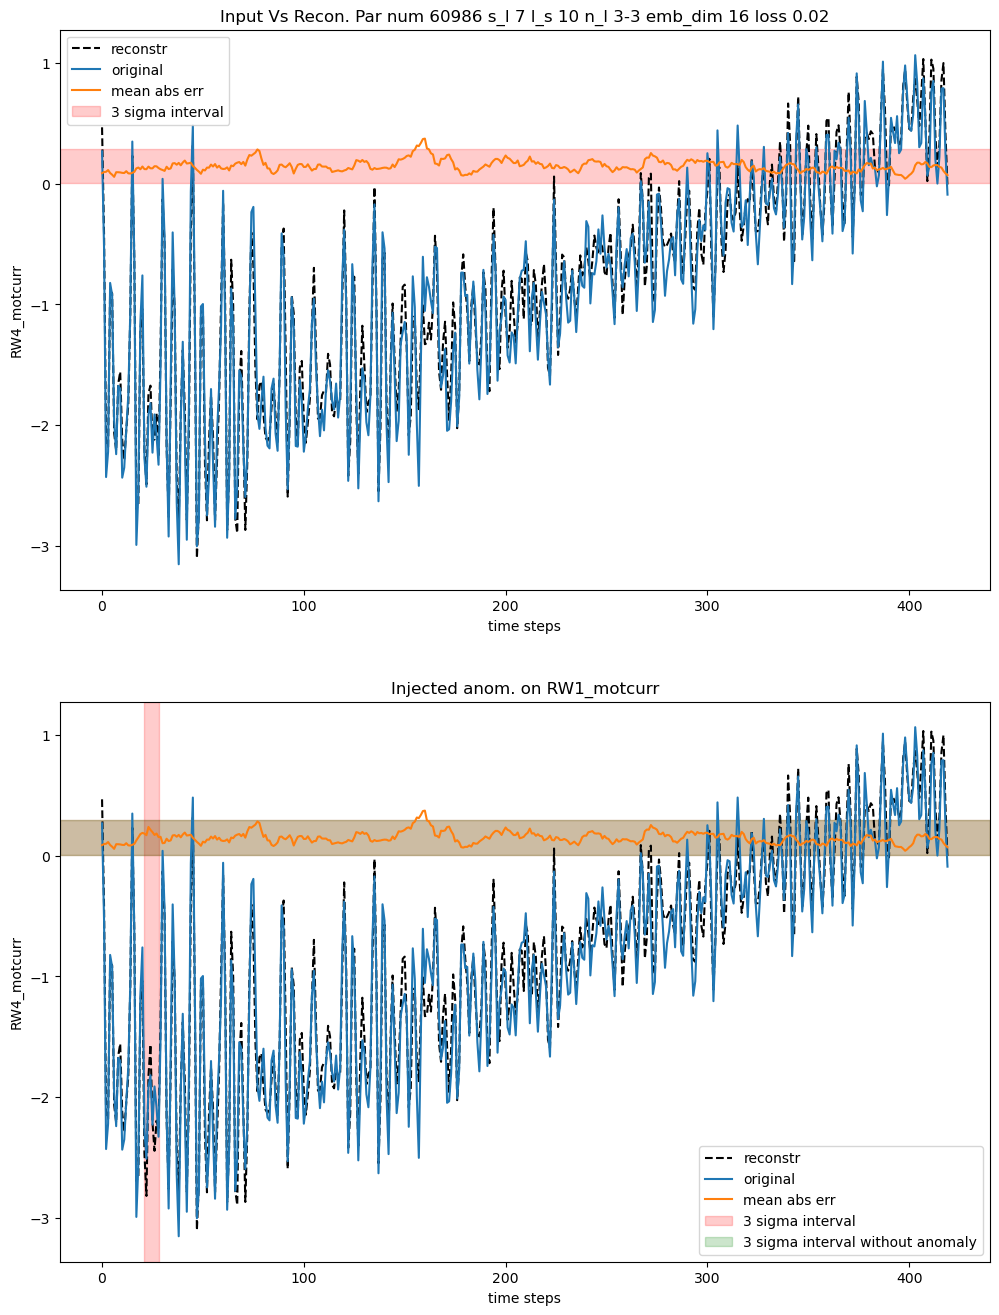

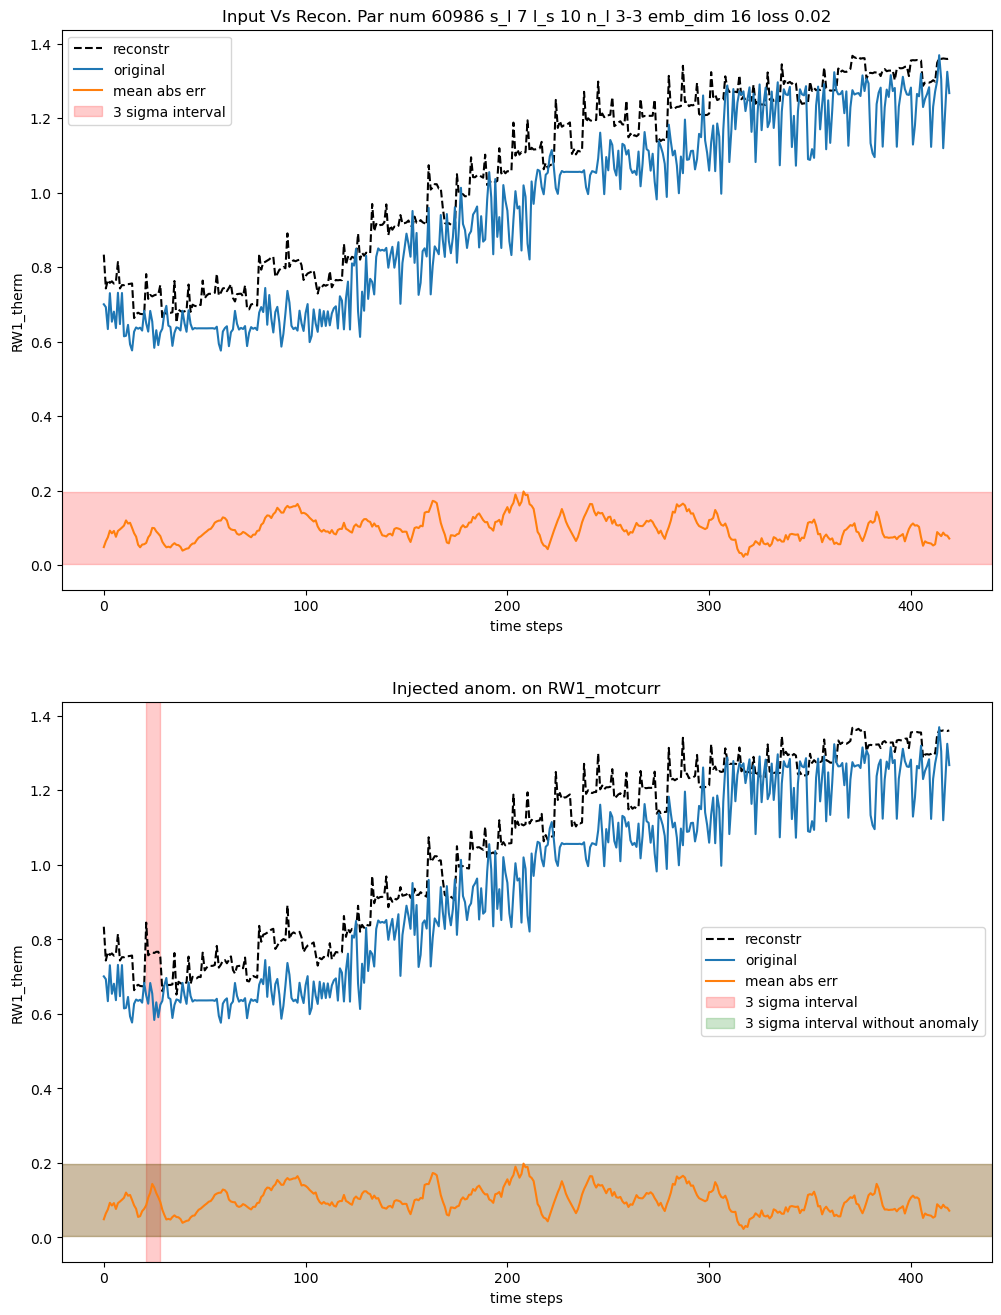

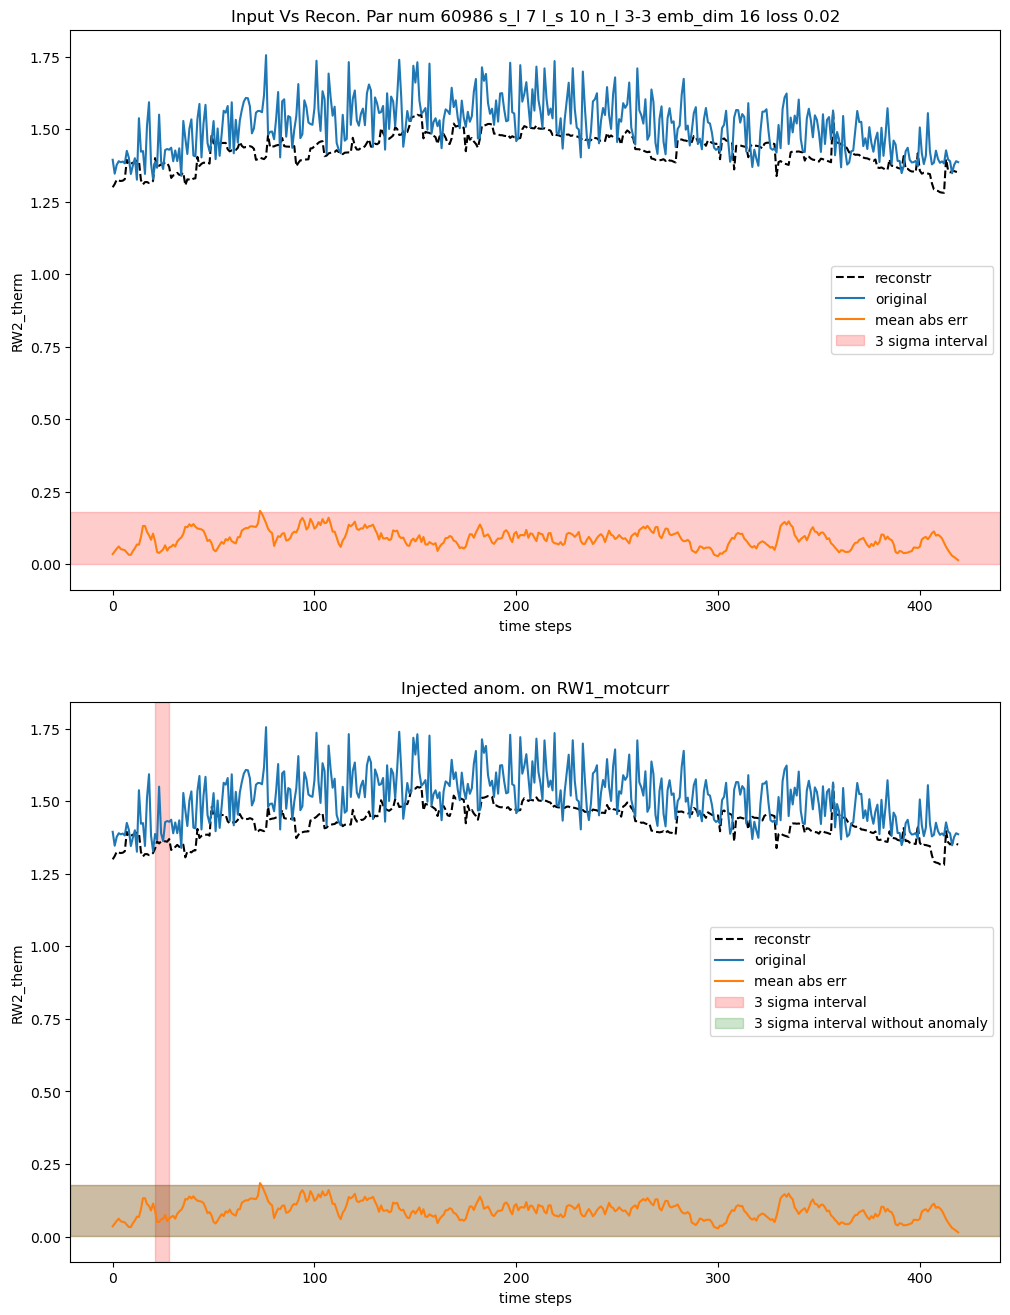

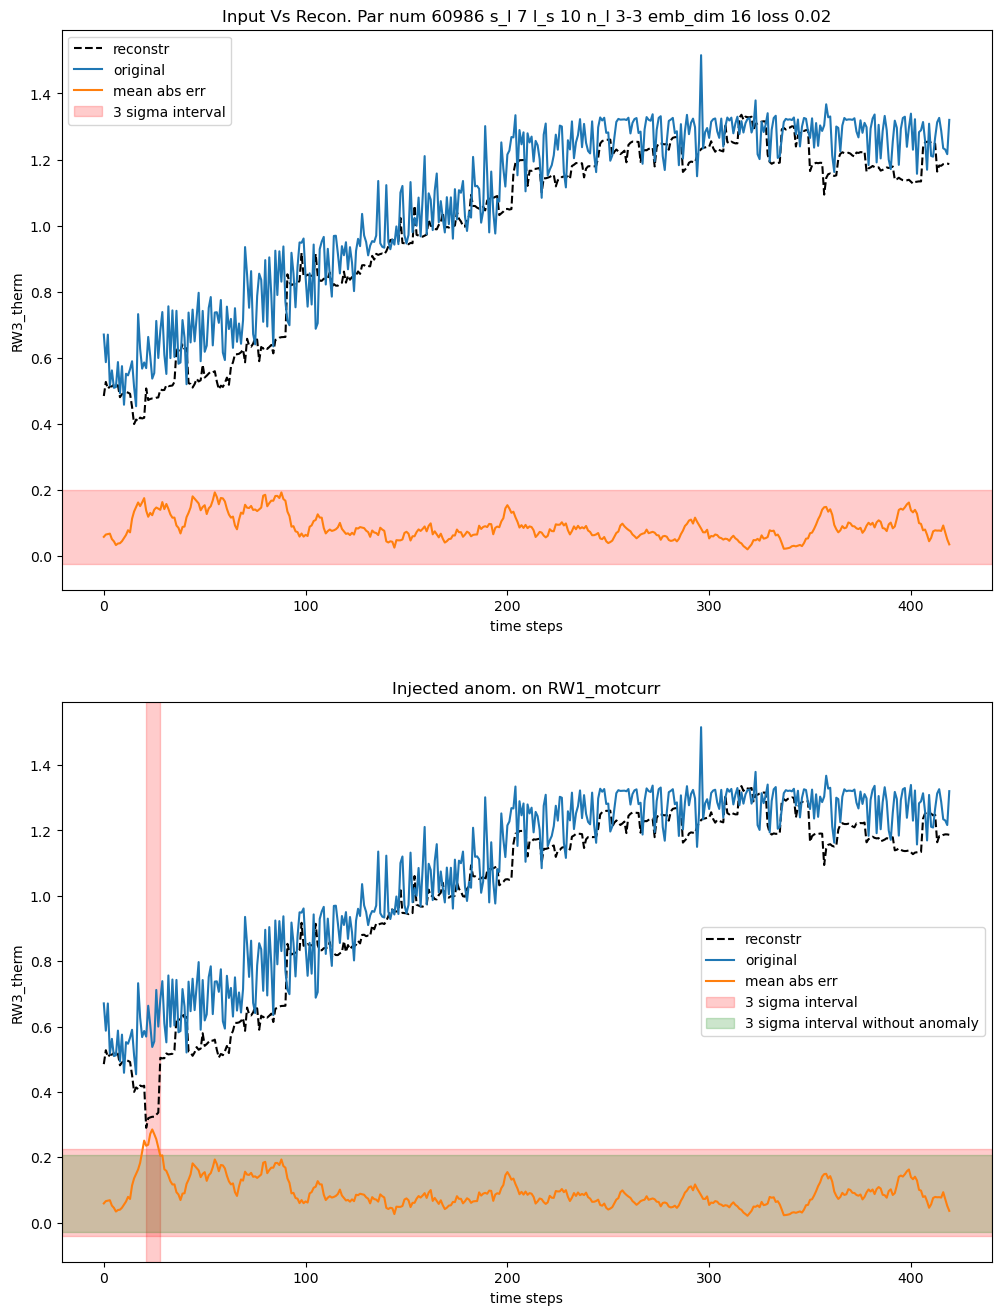

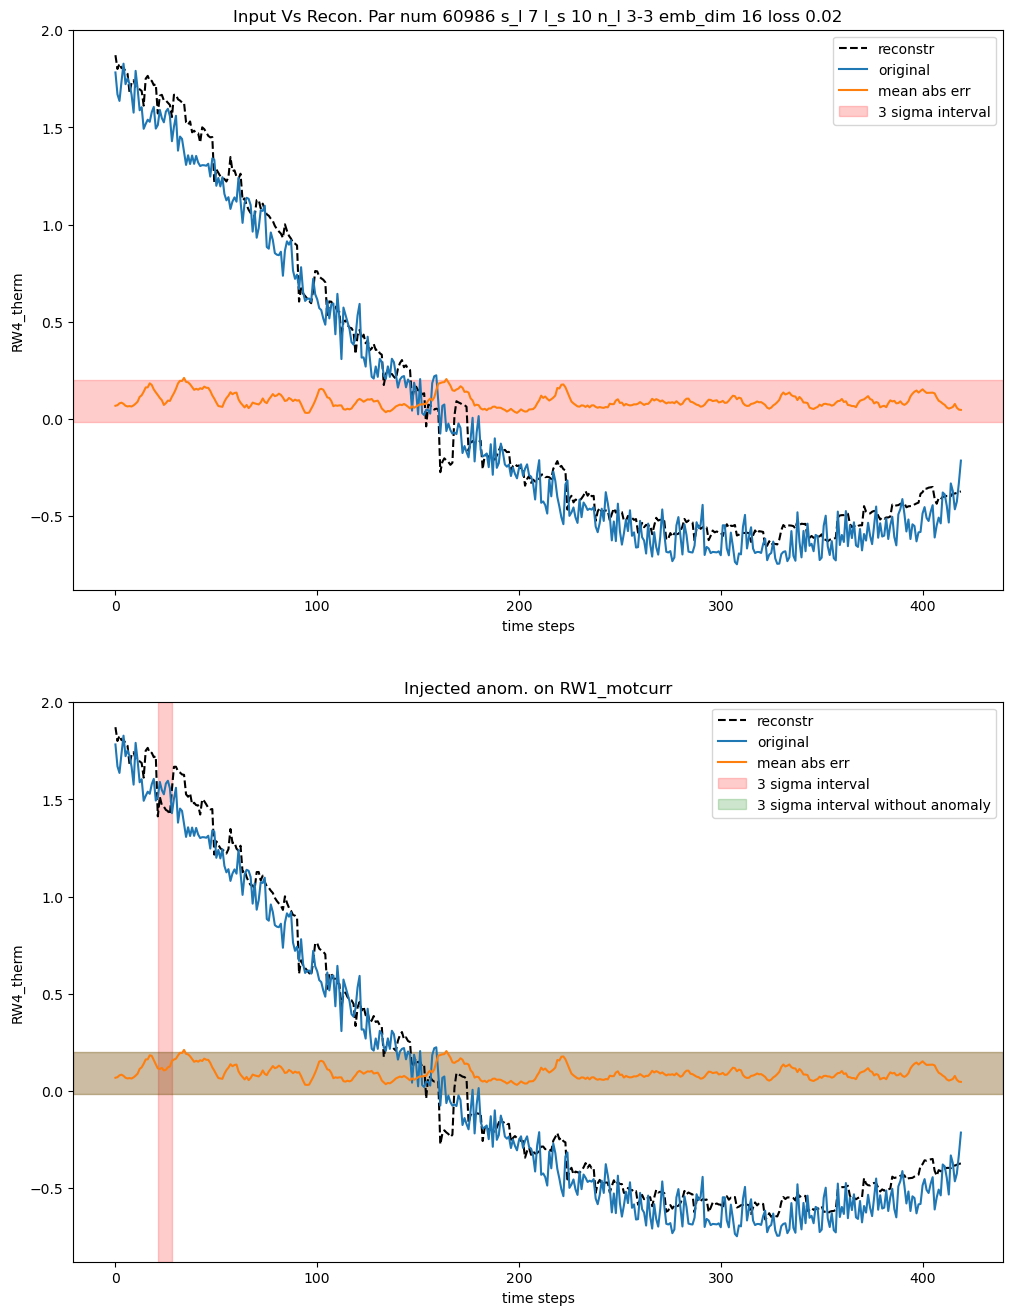

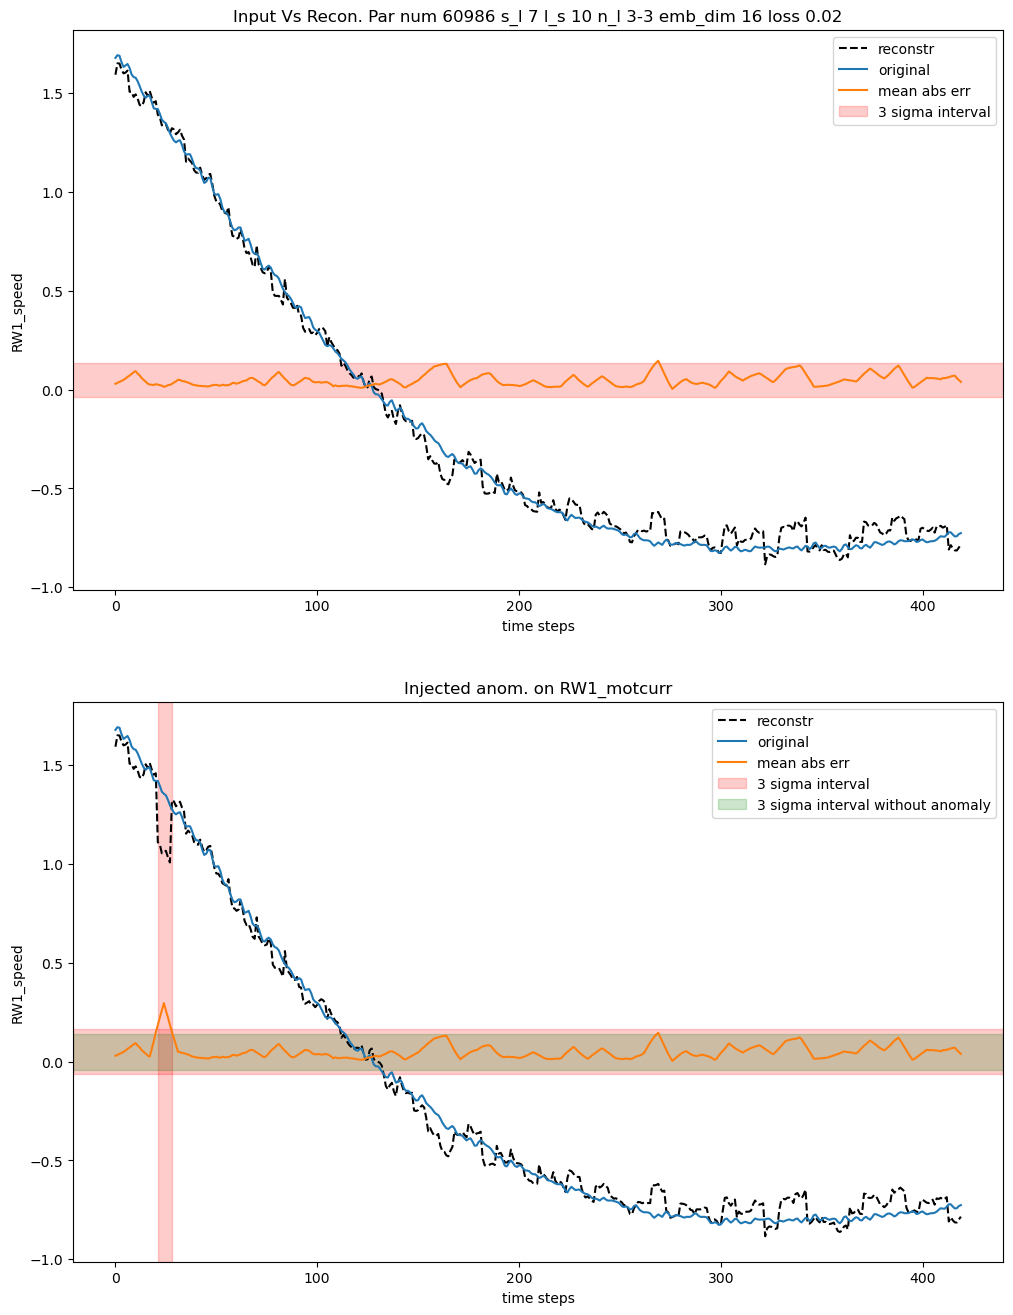

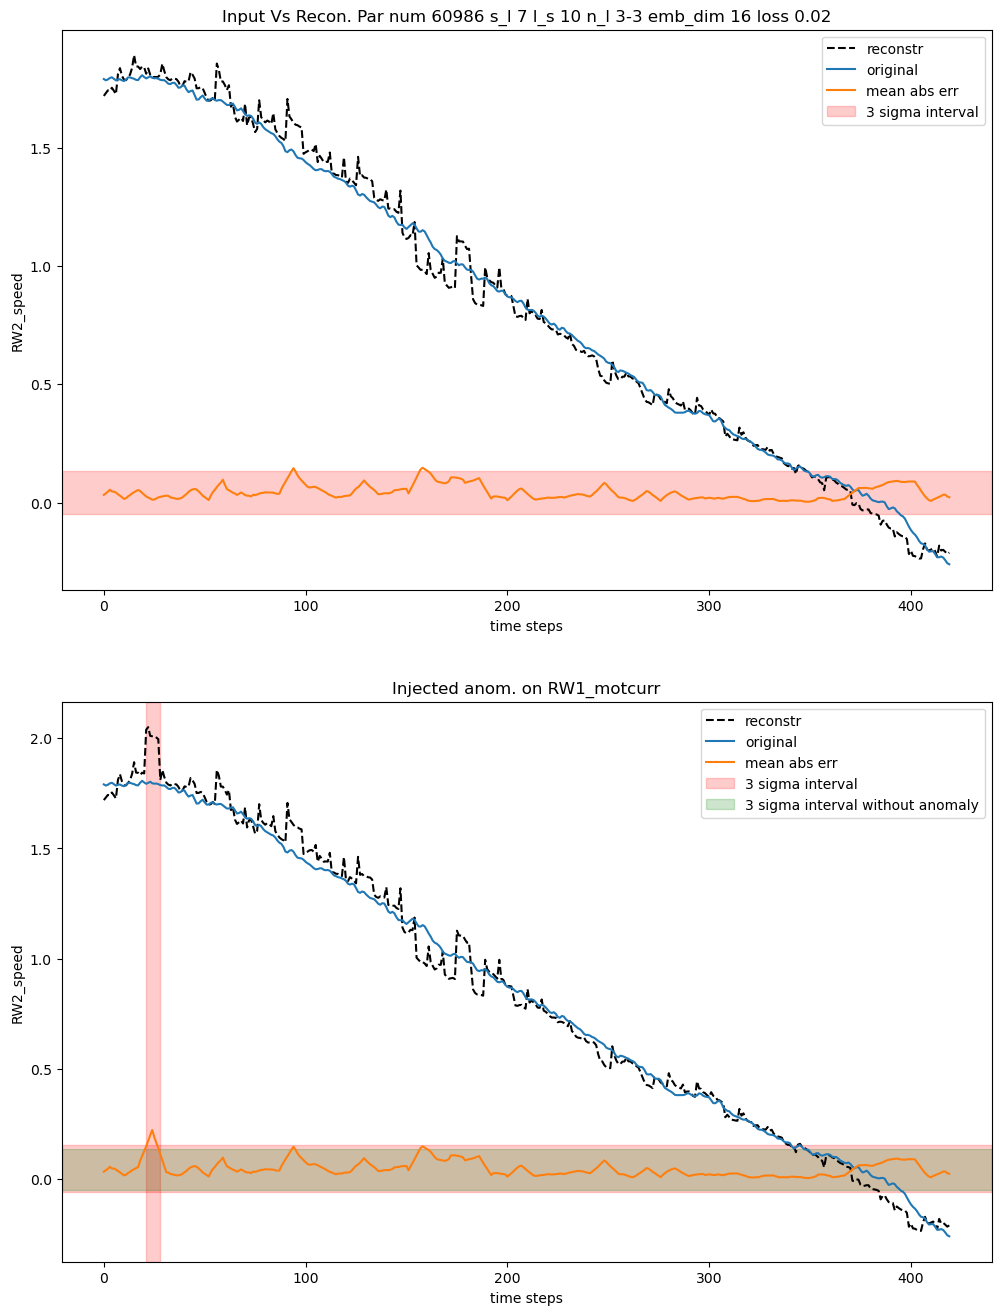

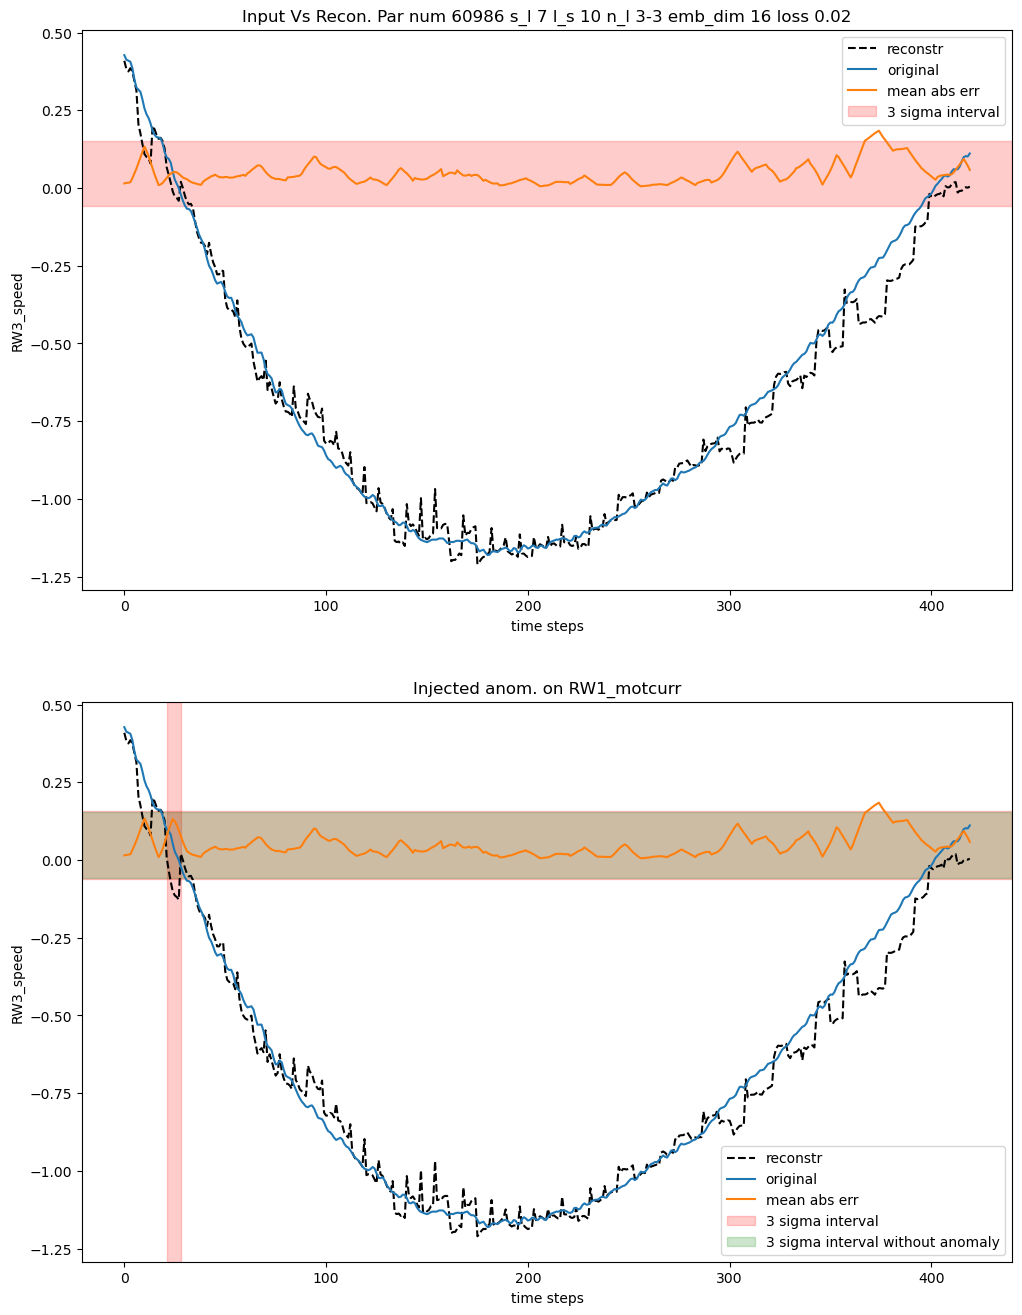

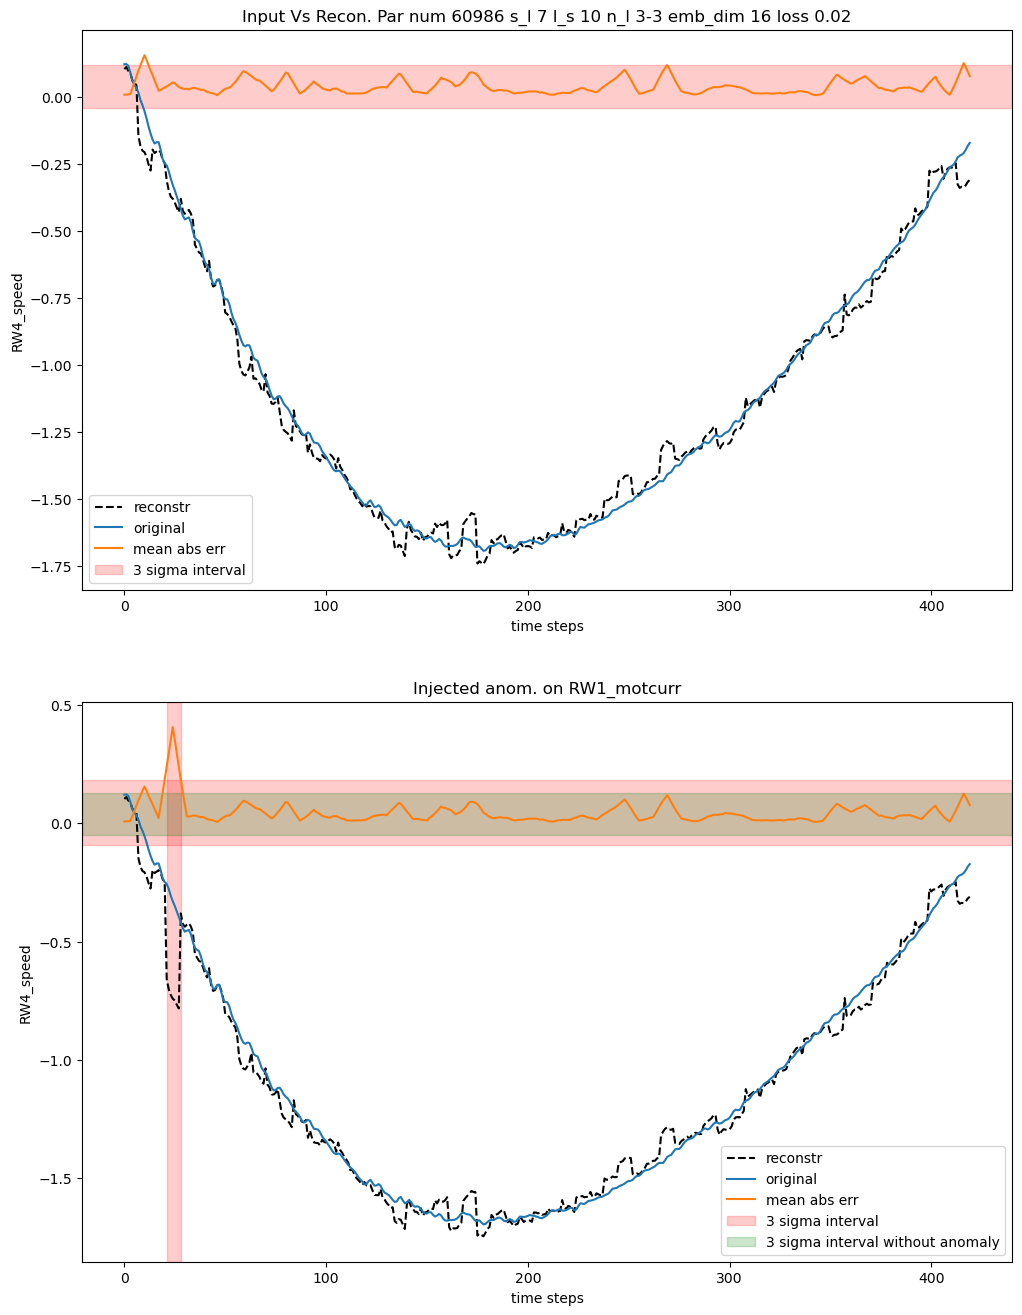

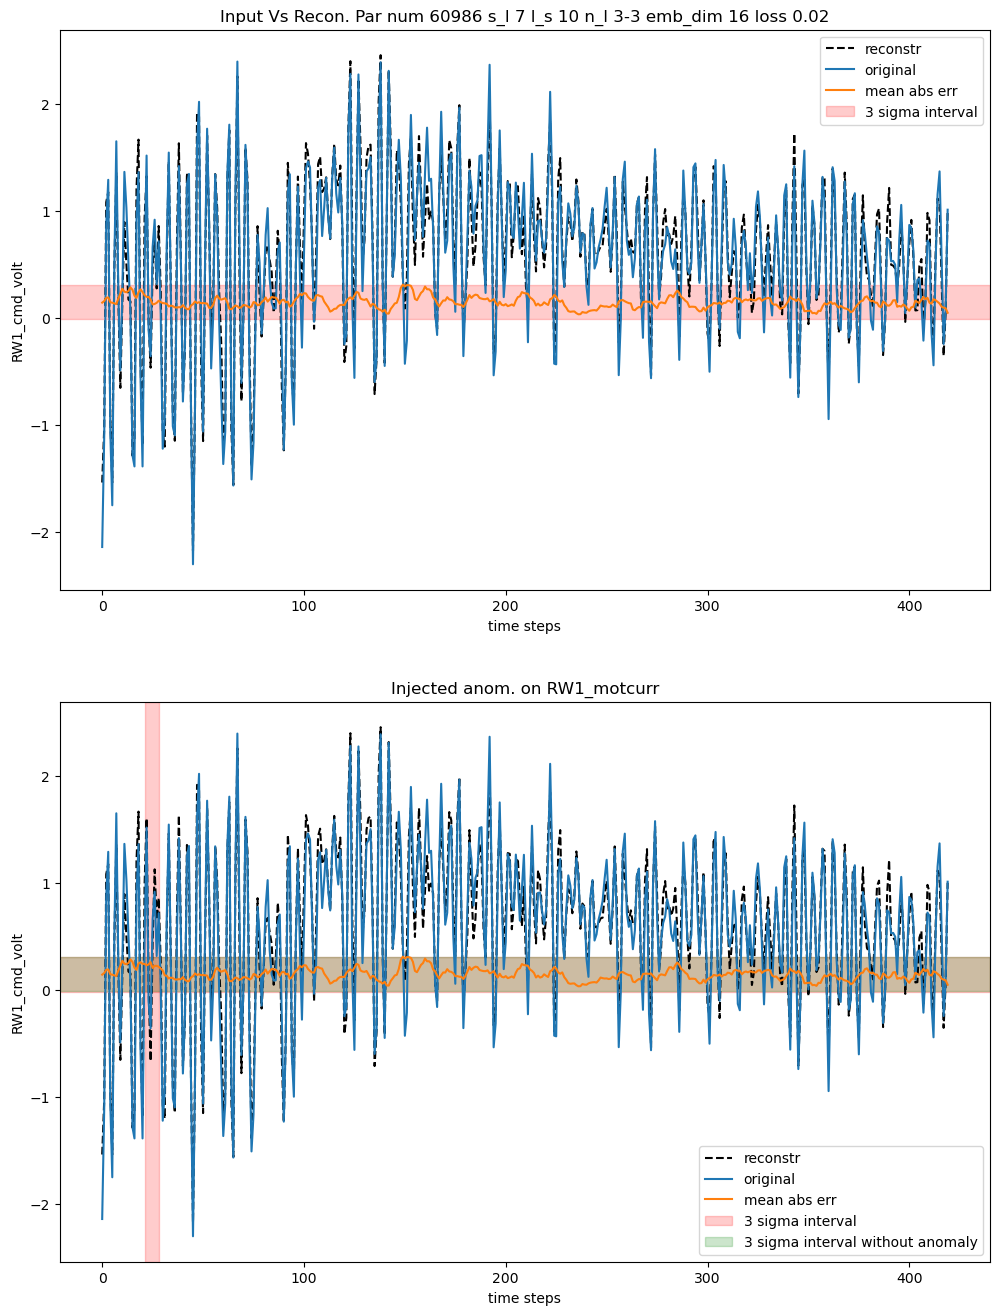

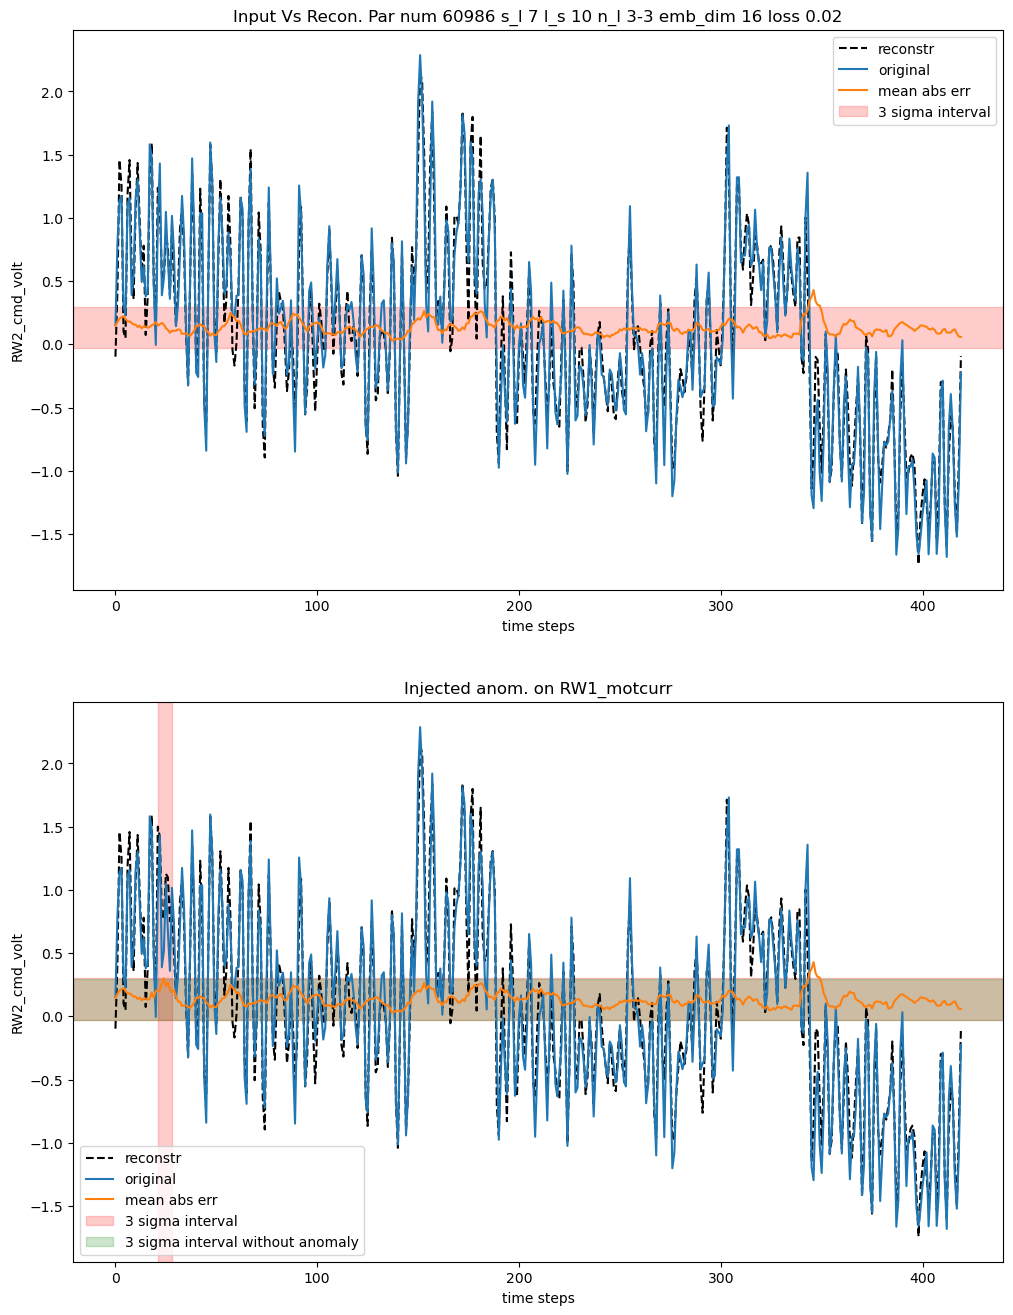

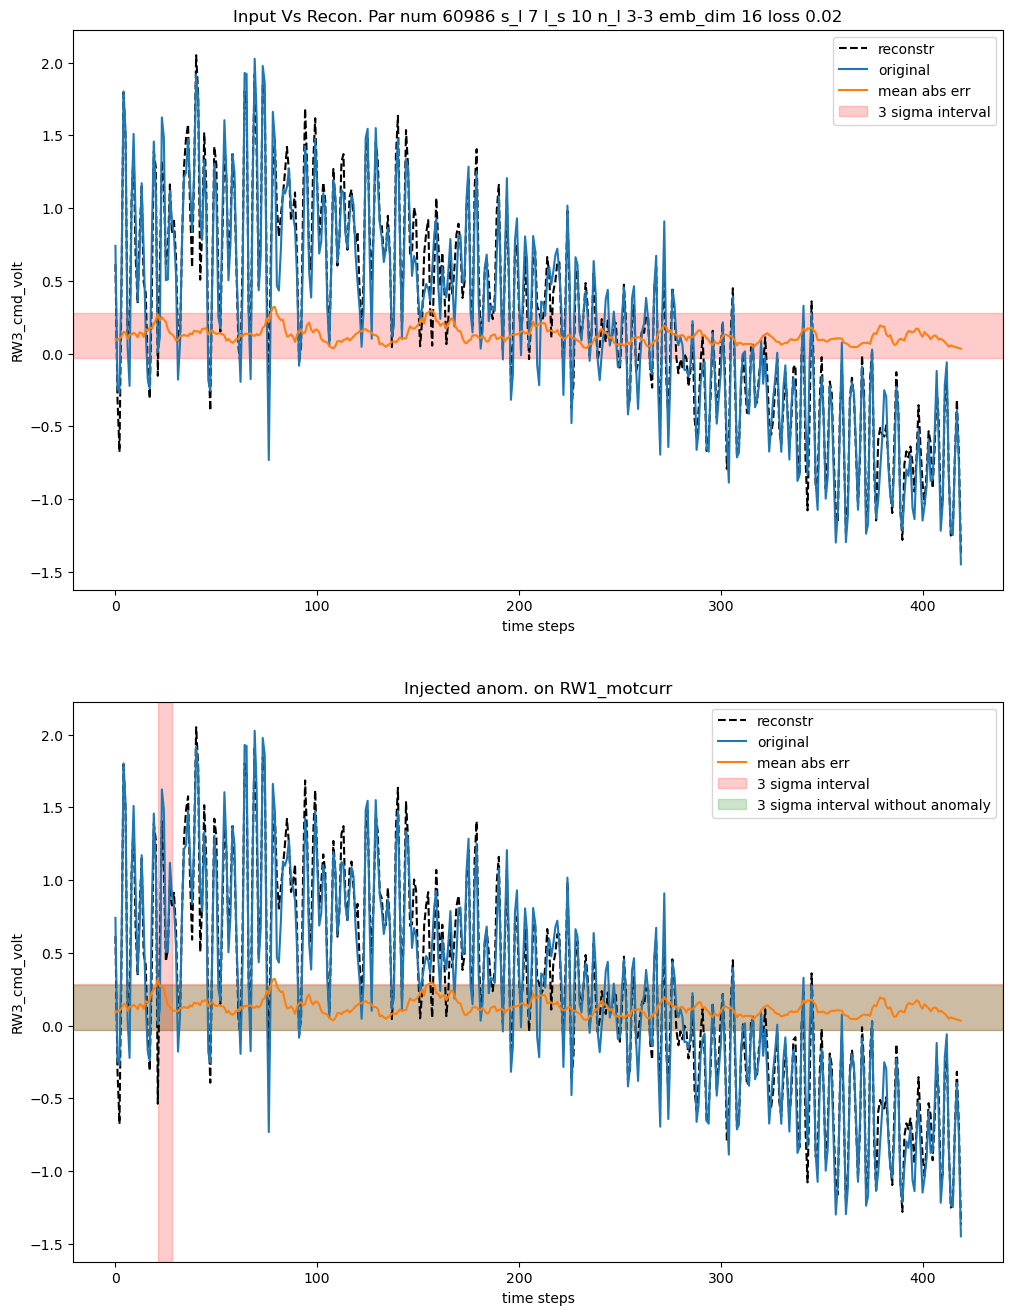

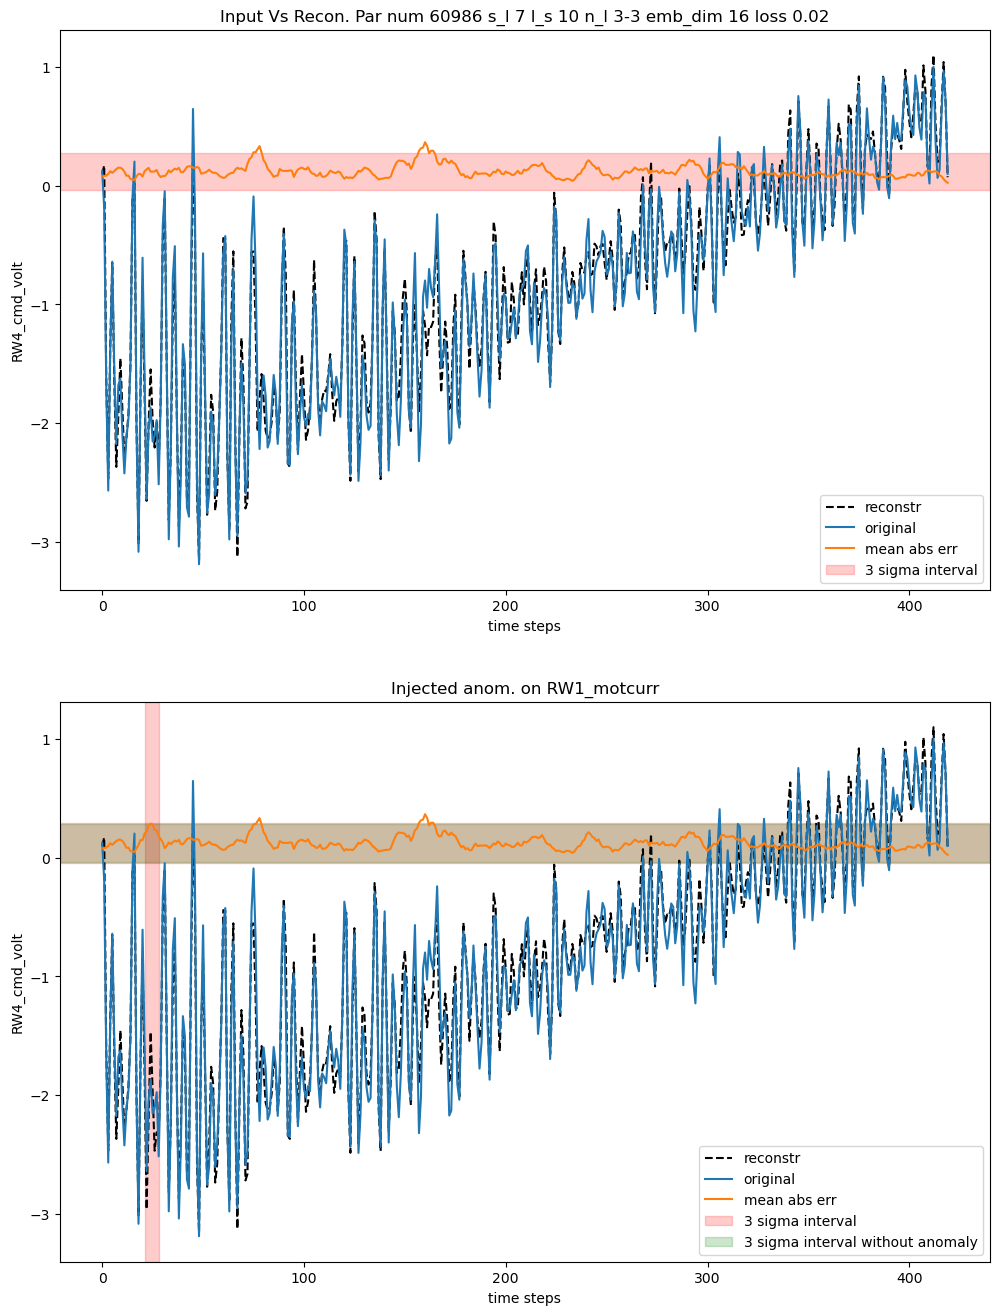

In [98]:
for i in range(x.shape[2]):
    fig, ax = plt.subplots(2,1, figsize=(12,16))

    ax[0].plot(yo.flatten(0,1)[:,i].to("cpu").detach().numpy(), 
               linestyle='--', label='reconstr', color='black')
    ax[0].plot(x.flatten(0,1)[:,i].to("cpu").detach().numpy(), label ='original')
    x_i = x.flatten(0,1)[:,i]
    y_o = yo.flatten(0,1)[:,i]

    loss_u = torch.nn.L1Loss(reduction='none')(y_o, x_i)
    loss_u = moving_average(loss_u.to("cpu").detach().numpy(), seq_len)

    ax[0].plot(loss_u, label ='mean abs err')
    ax[0].set_xlabel('time steps')
    ax[0].set_ylabel('{}'.format(cols[i]))
    ax[0].set_title('Input Vs Recon. Par num {} s_l {} l_s {} n_l {}-{} emb_dim {} loss {}'\
                    .format(par_nums, seq_len, 
                            latent_dim, params_conf['n_layers'],params_conf['n_layers'],
                            params_conf['embedding_dim'],
                            np.round(checkpoint['loss'],2)))
    #ax[0].hlines(np.mean(loss_u), 0, len(x_i), colors='green')
    ax[0].axhspan(np.mean(loss_u)-3*np.std(loss_u),
                  np.mean(loss_u)+3*np.std(loss_u)
                  , alpha=0.2, color='red', label='3 sigma interval')

    
    #ax[0].axhspan(np.mean(filtered)-3*np.std(loss_u),
    #              np.mean(loss_u)+3*np.std(loss_u)
    #              , alpha=0.2, color='green', label='3 sigma interval without anomaly')
    
    ax[0].legend()


    ax[1].plot(ya.flatten(0,1)[:,i].to("cpu").detach().numpy(), 
               linestyle='--', label='reconstr', color='black')
    ax[1].plot(xa.flatten(0,1)[:,i].to("cpu").detach().numpy(), label ='original')

    x_i = xa.flatten(0,1)[:,i]
    y_o = ya.flatten(0,1)[:,i]

    loss_u = torch.nn.L1Loss(reduction='none')(y_o, x_i)
    loss_u = moving_average(loss_u.to("cpu").detach().numpy(), seq_len)
    filtered = np.concatenate((loss_u[0:(batch[0])*seq_len], loss_u[(batch[0]+1)*seq_len:]))

    #y_test = x_i[(batch[0])*seq_len:(batch[0]+1)*seq_len].to("cpu").detach().numpy()
    #pred = y_o[(batch[0])*seq_len:(batch[0]+1)*seq_len].to("cpu").detach().numpy()
    #mape = np.mean(np.abs((y_test - pred) / y_test))

    ax[1].plot(loss_u, label ='mean abs err')
    ax[1].set_xlabel('time steps')
    ax[1].set_ylabel('{}'.format(cols[i]))
    ax[1].set_title('Injected anom. on {}'\
                    .format(cols[feats[0]]))
                           #,mape
                           #,loss))

    ax[1].axvspan((batch[0])*seq_len, (batch[0]+1)*seq_len, alpha=0.2, color='red')
    #ax[1].hlines(np.mean(loss_u), 0, len(x_i), colors='green', label = 'anom seq in {} with {} sigma deviation'\
    #             .format(feats[0], sigma))
    ax[1].axhspan(np.mean(loss_u)-3*np.std(loss_u),
                  np.mean(loss_u)+3*np.std(loss_u), alpha=0.2, color='red', label='3 sigma interval')
        
    ax[1].axhspan(np.mean(filtered)-3*np.std(filtered),
                  np.mean(filtered)+3*np.std(filtered)
                  , alpha=0.2, color='green', label='3 sigma interval without anomaly')
    ax[1].legend()

    if save:
        os.makedirs(path, exist_ok=True)
        plt.savefig(path + '{}_shift_{}_{}_sigma_{}_batch_{}.png'.format(cols[i],shift,sigma,i, num_batch))
